In [1]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import json
import torch
from __future__ import annotations
from transformers import AutoTokenizer, AutoModelForCausalLM
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt 

from mycelia.shared.helper import route_tokens_to_experts
from mycelia.shared.config import ValidatorConfig
from mycelia.shared.dataloader import get_dataloader
from mycelia.shared.expert_manager import is_expert_param
from mycelia.shared.modeling.mycelia import get_layer_expert_id

/home/isabella/crucible/subnet-MoE/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 2.9.1 available.


## Get Sources

In [2]:
# ---- Get config ----
rank = 0
config = ValidatorConfig()
config.task.data.batch_size = 1
config.task.data.sequence_length = 100

# ---- Get tokenizer ---- 
tokenizer = AutoTokenizer.from_pretrained(config.model.model_path)

# ---- Get dataloader ----
train_dataloader = get_dataloader(config, rank=rank, world_size=config.task.data.world_size, tokenizer=tokenizer)
iter_dataloader = iter(train_dataloader)

# ---- Get model ----
model = AutoModelForCausalLM.from_pretrained(
    config.model.model_path,
    torch_dtype=torch.float32,
    # device_map='cpu'
)
model.config.output_router_logits = True
model.eval()

2025-11-20 08:44:01 [warning  ] Cannot find the wallet key by name coldkey name: template_coldkey_name, hotkey name: template_hotkey_name, please make sure it has been set correctly if you are reloading from a config.json or use --hotkey_name & --coldkey_name when you are creating a config file from a template. [mycelia.shared.config] error=Generic error: Failed to get hotkey: FileNotFound("Keyfile at: /home/isabella/.bittensor/wallets/template_coldkey_name/hotkeys/template_hotkey_name does not exist.")


Too many dataloader workers: 4 (max is dataset.n_shards=1). Stopping 3 dataloader workers.


Too many dataloader workers: 4 (max is dataset.n_shards=1). Stopping 3 dataloader workers.


Loading checkpoint shards: 100%|██████████| 41/41 [01:41<00:00,  2.47s/it]


Qwen3NextForCausalLM(
  (model): Qwen3NextModel(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-2): 3 x Qwen3NextDecoderLayer(
        (linear_attn): Qwen3NextGatedDeltaNet(
          (act): SiLUActivation()
          (conv1d): Conv1d(8192, 8192, kernel_size=(4,), stride=(1,), padding=(3,), groups=8192, bias=False)
          (in_proj_qkvz): Linear(in_features=2048, out_features=12288, bias=False)
          (in_proj_ba): Linear(in_features=2048, out_features=64, bias=False)
          (norm): Qwen3NextRMSNormGated()
          (out_proj): Linear(in_features=4096, out_features=2048, bias=False)
        )
        (mlp): Qwen3NextSparseMoeBlock(
          (gate): Linear(in_features=2048, out_features=512, bias=False)
          (experts): ModuleList(
            (0-511): 512 x Qwen3NextMLP(
              (gate_proj): Linear(in_features=2048, out_features=512, bias=False)
              (up_proj): Linear(in_features=2048, out_features=512, bias=False)
           

## Model size check

In [3]:
shared_param = 0
expert_param = 0
for n, p in model.named_parameters():
    if is_expert_param(n):
        layer_id, expert_id = get_layer_expert_id(n)
        print(n, layer_id, expert_id)
        if expert_id == 1:  
            expert_param += p.numel()
    else:
        shared_param += p.numel()

num_experts = 10
trainable_param = expert_param * num_experts
total_param = shared_param + trainable_param

print('shared', shared_param / 1e9, '\nexpert_param', expert_param / 1e9, '\ntrainable param', trainable_param / 1e9, '\ntotal_param', total_param / 1e9)

model.layers.0.mlp.experts.0.gate_proj.weight 0 0
model.layers.0.mlp.experts.0.up_proj.weight 0 0
model.layers.0.mlp.experts.0.down_proj.weight 0 0
model.layers.0.mlp.experts.1.gate_proj.weight 0 1
model.layers.0.mlp.experts.1.up_proj.weight 0 1
model.layers.0.mlp.experts.1.down_proj.weight 0 1
model.layers.0.mlp.experts.2.gate_proj.weight 0 2
model.layers.0.mlp.experts.2.up_proj.weight 0 2
model.layers.0.mlp.experts.2.down_proj.weight 0 2
model.layers.0.mlp.experts.3.gate_proj.weight 0 3
model.layers.0.mlp.experts.3.up_proj.weight 0 3
model.layers.0.mlp.experts.3.down_proj.weight 0 3
model.layers.0.mlp.experts.4.gate_proj.weight 0 4
model.layers.0.mlp.experts.4.up_proj.weight 0 4
model.layers.0.mlp.experts.4.down_proj.weight 0 4
model.layers.0.mlp.experts.5.gate_proj.weight 0 5
model.layers.0.mlp.experts.5.up_proj.weight 0 5
model.layers.0.mlp.experts.5.down_proj.weight 0 5
model.layers.0.mlp.experts.6.gate_proj.weight 0 6
model.layers.0.mlp.experts.6.up_proj.weight 0 6
model.layers.0

## Sampling expert by model inference  

In [4]:
model.model.layers[0].mlp

Qwen3NextSparseMoeBlock(
  (gate): Linear(in_features=2048, out_features=512, bias=False)
  (experts): ModuleList(
    (0-511): 512 x Qwen3NextMLP(
      (gate_proj): Linear(in_features=2048, out_features=512, bias=False)
      (up_proj): Linear(in_features=2048, out_features=512, bias=False)
      (down_proj): Linear(in_features=512, out_features=2048, bias=False)
      (act_fn): SiLUActivation()
    )
  )
  (shared_expert): Qwen3NextMLP(
    (gate_proj): Linear(in_features=2048, out_features=512, bias=False)
    (up_proj): Linear(in_features=2048, out_features=512, bias=False)
    (down_proj): Linear(in_features=512, out_features=2048, bias=False)
    (act_fn): SiLUActivation()
  )
  (shared_expert_gate): Linear(in_features=2048, out_features=1, bias=False)
)

In [5]:
model.eval()
outputs = []
for i in range(20):
    tokens = next(iter_dataloader)
    for k, v in tokens.items():
        tokens[k] = v[0]
    del tokens['labels']
    with torch.no_grad():
        tokens.to(model.device)
        output = model(**tokens)
    outputs.append(output)

In [6]:
counts_per_layer = {}
for layer_id in range(len(outputs[0].router_logits)): 
    all_selected_experts = []
    for output in outputs: 
        selected_experts, routing_weight = route_tokens_to_experts(output.router_logits[layer_id])
        all_selected_experts.append(selected_experts)

    flat = torch.concat(all_selected_experts).flatten().tolist()
    counts_per_layer[layer_id] = Counter(flat)

avg required expert to reach 0.5 selection th:  tensor(44.1250)


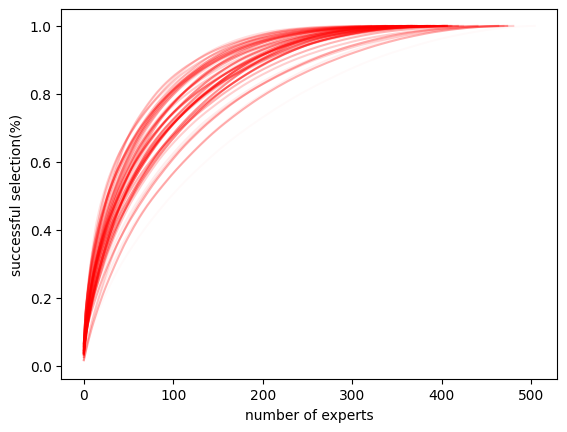

In [10]:
layer_id = 30
selection_th = 0.5

idx_th = [] 
for layer_id in range(48):
    count = torch.tensor(list(counts_per_layer[layer_id].values()))
    count_norm = (count / count.sum()).sort(descending = True)[0]

    cumsum = torch.cumsum(count_norm, dim=0)
    idx = torch.searchsorted(cumsum, selection_th)
    plt.plot(cumsum, color = 'red', alpha = layer_id / 100)
    idx_th.append(idx)

plt.ylabel('successful selection(%)')
plt.xlabel('number of experts')

print(f"avg required expert to reach {selection_th} selection th: ", sum(idx_th) / len(idx_th))

## Writing into the task setup

In [11]:
start_expert_id = 0
num_experts = 5
expert_group_assignment = {layer_id : [(mycelia_index, base_model_index) for mycelia_index, (base_model_index, count) in zip(range(start_expert_id, start_expert_id + num_experts), counts.most_common(num_experts))] for layer_id, counts in counts_per_layer.items()}

# with open(config.task.path/'expert_assignment.json', "w") as f:
with open('/home/isabella/crucible/subnet-MoE/expert_groups/exp_dummy/expert_assignment.json', "w") as f:
    json.dump(expert_group_assignment, f)

## Check expert manager

In [12]:
from mycelia.shared.expert_manager import ExpertManager
em = ExpertManager(config)
em.expert_group_assignment

{0: {0: [(5, 79),
   (6, 413),
   (7, 57),
   (8, 474),
   (9, 183),
   (10, 285),
   (11, 120),
   (12, 430),
   (13, 319),
   (14, 332),
   (15, 160),
   (16, 262),
   (17, 200),
   (18, 337),
   (19, 342),
   (20, 25),
   (21, 16),
   (22, 193),
   (23, 195),
   (24, 226)],
  1: [(5, 362),
   (6, 177),
   (7, 493),
   (8, 265),
   (9, 15),
   (10, 272),
   (11, 138),
   (12, 471),
   (13, 161),
   (14, 477),
   (15, 405),
   (16, 155),
   (17, 234),
   (18, 402),
   (19, 476),
   (20, 368),
   (21, 72),
   (22, 240),
   (23, 435),
   (24, 88)],
  2: [(5, 32),
   (6, 89),
   (7, 106),
   (8, 95),
   (9, 104),
   (10, 387),
   (11, 465),
   (12, 87),
   (13, 20),
   (14, 456),
   (15, 390),
   (16, 469),
   (17, 155),
   (18, 131),
   (19, 428),
   (20, 144),
   (21, 318),
   (22, 321),
   (23, 499),
   (24, 251)],
  3: [(5, 168),
   (6, 435),
   (7, 302),
   (8, 380),
   (9, 65),
   (10, 275),
   (11, 19),
   (12, 455),
   (13, 112),
   (14, 443),
   (15, 274),
   (16, 472),
   (17, 